In [32]:
import typing

# import wget
from torchvision import transforms
from torchvision.datasets import ImageFolder
from image_classification_simulation.data.data_loader import MyDataModule
from torch.utils.data import DataLoader

class Office31Loader(MyDataModule):  # pragma: no cover
    """Data module class that prepares dataset parsers and instantiates data loaders.
    Parameters
    ----------
    MyDataModule : DataModule class
        Template DataModule class
    """
    # We are going to use the amazon data (most similar to a catalog of online products)

    def __init__(
        self,
        data_dir: typing.AnyStr,
        hyper_params: typing.Dict[typing.AnyStr, typing.Any],
    ):
        """Validates the hyperparameter config dictionary and sets up internal attributes.
        Parameters
        ----------
        data_dir : string
            Directory path that the data will be downloaded and stored
        hyper_params : dictionary
            Hyperparameters relevant to the dataloader module.
        """
        super().__init__(data_dir, hyper_params)
        self.num_unique_labels = 31

        if "num_workers" in hyper_params:
            self.num_workers = hyper_params["num_workers"]
        else:
            self.num_workers = 1
            print("Number of workers set to:", self.num_workers)

        if "image_size" in hyper_params:
            self.image_size = hyper_params["image_size"]
        else:
            self.image_size = 300
            print("image size set to:", self.image_size)

        self.train_set_transformation = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
            ]
        )

        self.test_set_transformation = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )

    def setup(self, stage: str = None):
        """Parses and splits all samples across the train/valid/test parsers.
        Parameters
        ----------
        stage : string, optional
            Stage of training (training, validation, testing), by default None
        """

        # here, we will actually assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:

            self.train_set = ImageFolder(
                root=self.data_dir, transform=self.train_set_transformation
            )

            self.val_set = ImageFolder(
                root=self.data_dir, transform=self.train_set_transformation
            )

        if stage == "test" or stage is None:

            self.test_set = ImageFolder(
                root=self.data_dir, transform=self.test_set_transformation
            )

    def train_dataloader(self) -> DataLoader:
        """Creates the training dataloader using the training data parser.
        Returns
        -------
        DataLoader
            returns a pytorch DataLoader class
        """
        return DataLoader(
            self.train_set,
            batch_size=self.batch_size,
            batch_sampler=None,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=None,
        )

    def val_dataloader(self) -> DataLoader:
        """Creates the validation dataloader using the validation data parser.
        Returns
        -------
        DataLoader
            returns a pytorch DataLoader class
        """
        return DataLoader(
            self.val_set,
            batch_size=self.batch_size,
            batch_sampler=None,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=None,
        )

    def test_dataloader(self) -> DataLoader:
        """Creates the testing dataloader using the testing data parser.
        Returns
        -------
        DataLoader
            returns a pytorch DataLoader class
        """
        return DataLoader(
            self.test_set,
            batch_size=self.batch_size,
            batch_sampler=None,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=None,
        )




In [37]:
args_dict = {"batch_size": 32, "image_size": 300}
office31_loader = Office31Loader("./data/domain_adaptation_images/amazon/images/", args_dict)
office31_loader.setup(stage="fit")

Number of workers set to: 1


TypeError: Invalid shape (3, 300, 300) for image data

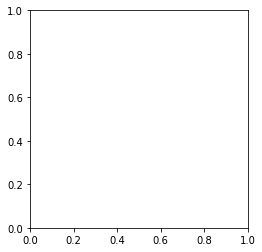

In [36]:



plt.imshow(office31_loader.train_set[0][0])
plt.axis('off')
plt.show()

In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
#from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
#auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '0B4IapRTv9pJ1WGZVd1VDMmhwdlE'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

ApplicationDefaultCredentialsError: The Application Default Credentials are not available. They are available if running in Google Compute Engine. Otherwise, the environment variable GOOGLE_APPLICATION_CREDENTIALS must be defined pointing to a file defining the credentials. See https://developers.google.com/accounts/docs/application-default-credentials for more information.

In [28]:
import os
import typing

import numpy as np
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
# __TODO__ change the dataloader to suit your needs...


def get_data(
    data_folder: typing.AnyStr,
    prefix: typing.AnyStr
) -> typing.Tuple[np.ndarray, np.ndarray]:  # pragma: no cover
    """Function to load data into memory.

    Args:
        data_folder (str): Path of the folder where the data lives.
        prefix (str): The data split to target, i.e. "train" or "dev.

    Returns:
        in_data (np.array): Input data.
        tar_data (np.array): Target data.
    """
    inputs = []
    with open(os.path.join(data_folder, '{}.input'.format(prefix))) as in_stream:
        for line in in_stream:
            inputs.append([float(x) for x in line.split()])
    in_data = np.array(inputs, dtype=np.float32)
    targets = []
    with open(os.path.join(data_folder, '{}.target'.format(prefix))) as in_stream:
        for line in in_stream:
            targets.append(float(line))
    tar_data = np.array(targets, dtype=np.float32)
    return in_data, tar_data


class Office31(Dataset):  # pragma: no cover
    """Dataset class for iterating over the data."""

    def __init__(
        self,
        input_data: np.ndarray,
        target_data: np.ndarray,
    ):
        """Initialize Office31.

        Args:
            input_data (np.array): Input data.
            target_data (np.array): Target data.
        """
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        """Return the number of data items in MyDataset."""
        return len(self.input_data)

    def __getitem__(
        self,
        index: int,
    ):
        """__getitem__.

        Args:
            index (int): Get index item from the dataset.
        """
        target_example = self.target_data[index]
        input_example = self.input_data[index]
        return input_example, target_example




In [29]:
class Office31Module(pl.LightningDataModule):  # pragma: no cover
    """Data module class that prepares dataset parsers and instantiates data loaders."""

    def __init__(
        self,
        data_dir: typing.AnyStr,
        hyper_params: typing.Dict[typing.AnyStr, typing.Any],
    ):
        """Validates the hyperparameter config dictionary and sets up internal attributes."""
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = hyper_params['batch_size']
        self.train_data_parser, self.dev_data_parser = None, None

    def prepare_data(self):
        """Downloads/extracts/unpacks the data if needed (we don't)."""
        pass

    def setup(self, stage=None):
        """Parses and splits all samples across the train/valid/test parsers."""
        # here, we will actually assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            train_input, train_target = get_data(self.data_dir, 'train')
            self.train_data_parser = Office31(train_input, train_target)
            dev_input, dev_target = get_data(self.data_dir, 'dev')
            self.dev_data_parser = Office31(dev_input, dev_target)
        if stage == 'test' or stage is None:
            raise NotImplementedError  # __TODO__: add code to instantiate the test data parser here

    def train_dataloader(self) -> DataLoader:
        """Creates the training dataloader using the training data parser."""
        return DataLoader(self.train_data_parser, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        """Creates the validation dataloader using the validation data parser."""
        return DataLoader(self.dev_data_parser, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        """Creates the testing dataloader using the testing data parser."""
        raise NotImplementedError  # __TODO__: add code to instantiate the test data loader here


def load_data(data_dir, hyper_params):  # pragma: no cover
    """Prepare the data into datasets.

    Args:
        data_dir (str): path to the folder containing the data
        hyper_params (dict): hyper parameters from the config file

    Returns:
        datamodule (obj): the data module used to prepare/instantiate data loaders.
    """
    # __TODO__ if you have different data modules, add whatever code is needed to select them here
    return Office31Module(data_dir, hyper_params)

In [4]:
import typing
#import wget
from torchvision import transforms
from torchvision.datasets import ImageFolder
from image_classification_simulation.data.data_loader import MyDataModule
from torch.utils.data import DataLoader, random_split










{'back_pack': 0, 'bike': 1, 'bike_helmet': 2, 'bookcase': 3, 'bottle': 4, 'calculator': 5, 'desk_chair': 6, 'desk_lamp': 7, 'desktop_computer': 8, 'file_cabinet': 9, 'headphones': 10, 'keyboard': 11, 'laptop_computer': 12, 'letter_tray': 13, 'mobile_phone': 14, 'monitor': 15, 'mouse': 16, 'mug': 17, 'paper_notebook': 18, 'pen': 19, 'phone': 20, 'printer': 21, 'projector': 22, 'punchers': 23, 'ring_binder': 24, 'ruler': 25, 'scissors': 26, 'speaker': 27, 'stapler': 28, 'tape_dispenser': 29, 'trash_can': 30}


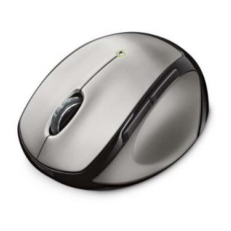

In [45]:
import matplotlib.pyplot as plt

dataset = ImageFolder("./data/domain_adaptation_images/amazon/images")
print(dataset.class_to_idx)
#print(dataset.imgs)

#dataset = ImageFolder('data1/dogcat_2/', transform=transform)


plt.imshow(dataset[1500][0])
plt.axis('off')
plt.show()

In [22]:
class Office31Loader(MyDataModule):  # pragma: no cover
    """Data module class that prepares dataset parsers and instantiates data loaders.
    Parameters
    ----------
    MyDataModule : DataModule class
        Template DataModule class
    """

    # We are going to use the amazon data folder here as it is the most similar to a catalog of online products

    def __init__(
        self,
        data_dir: typing.AnyStr,
        hyper_params: typing.Dict[typing.AnyStr, typing.Any],
    ):
        """Validates the hyperparameter config dictionary and sets up internal attributes.
        Parameters
        ----------
        data_dir : string
            Directory path that the data will be downloaded and stored
        hyper_params : dictionary
            Hyperparameters relevant to the dataloader module.
        """
        super().__init__(data_dir, hyper_params)
        self.num_unique_labels = 31

        if "num_workers" in hyper_params:
            self.num_workers = hyper_params["num_workers"]
        else:
            self.num_workers = 1
            print("Number of workers set to:", self.num_workers)

        if "image_size" in hyper_params:
            self.image_size = hyper_params["image_size"]
        else:
            self.image_size = 300
            print("image size set to:", self.image_size)

        self.train_set_transformation = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
            ]
        )

        self.test_set_transformation = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )

    def setup(self, stage: str = None):
        """Parses and splits all samples across the train/valid/test parsers.
        Parameters
        ----------
        stage : string, optional
            Stage of training (training, validation, testing), by default None
        """



        # here, we will actually assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:


            self.train_set = ImageFolder(
                root=self.data_dir, 
                transform=self.train_set_transformation
                )

            self.val_set = ImageFolder(
                root=self.data_dir, 
                transform=self.train_set_transformation
                )
                
        if stage == "test" or stage is None:

            self.test_set = ImageFolder(
                root=self.data_dir, 
                transform=self.test_set_transformation
                )
            

    def train_dataloader(self) -> DataLoader:
        """Creates the training dataloader using the training data parser.
        Returns
        -------
        DataLoader
            returns a pytorch DataLoader class
        """
        return DataLoader(
            self.train_set,
            batch_size=self.batch_size,
            batch_sampler=None,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=None,
        )

    def val_dataloader(self) -> DataLoader:
        """Creates the validation dataloader using the validation data parser.
        Returns
        -------
        DataLoader
            returns a pytorch DataLoader class
        """
        return DataLoader(
            self.val_set,
            batch_size=self.batch_size,
            batch_sampler=None,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=None,
        )

    def test_dataloader(self) -> DataLoader:
        """Creates the testing dataloader using the testing data parser.
        Returns
        -------
        DataLoader
            returns a pytorch DataLoader class
        """
        return DataLoader(
            self.test_set,
            batch_size=self.batch_size,
            batch_sampler=None,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=None,
        )


In [38]:
hyperparams_dict = {"batch_size": 32, "image_size": 300}
office31_loader = Office31Loader("./data/domain_adaptation_images/amazon/images",hyperparams_dict)
office31_loader.setup()





Number of workers set to: 1
